In [246]:
import os
import feedparser
import requests
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Etape 1 : Extraction des flux RSS

In [ ]:
def extract_rss_entries():
    urls = [
        "https://www.cert.ssi.gouv.fr/avis/feed",
        "https://www.cert.ssi.gouv.fr/alerte/feed"
    ]
    entries = []
    for url in urls:
        feed = feedparser.parse(url)
        for entry in feed.entries:
            entries.append({
                'id': entry.link.split("/")[-2],
                'title': entry.title,
                'link': entry.link,
                'type': "Alerte" if "alerte" in url else "Avis",
                'date': entry.published
            })
    return entries

In [ ]:
rss_entries = extract_rss_entries()
print(f"Nombre d'entrées RSS : {len(rss_entries)}")
# print(rss_entries)

# Etape 2 : Extraction des CVE

In [ ]:
def extract_cves_from_json(entry_link):
    try:
        json_url = entry_link + "/json/"
        response = requests.get(json_url)
        data = response.json() # fichier JSON complet de l'entrée RSS

        # Extraction des CVE reference dans la clé cves du dict data
        cve_refs = data.get("cves", [])

        # Attention, il s’agit d’une liste des dictionnaires avec name et url comme clés
        """print("CVE références :", cve_refs)
        print("Type de références", type(cve_refs))
        print("Type des éléments de la liste", type(cve_refs[0]))"""

        # Extraction des CVE avec une regex
        cve_pattern = r"CVE-\d{4}-\d{4,7}"
        cve_list = list(set(re.findall(cve_pattern, str(data))))
        """print("CVE trouvés :", cve_list)"""

        # Retourne la liste de CVE référence pour l'entrée RSS entrée en argument + le JSON complet de l'entrée RSS
        return cve_refs, data
    except:
        return [], {}


In [ ]:
first_entry = rss_entries[0]
cve_refs, full_json = extract_cves_from_json(first_entry["link"])

# Etape 3 : Enrichissement des CVE

In [ ]:
def enrich_cve(cve_id):
    mitre = {}
    epss_score = None

    # API CVE de Mitre
    try:
        mitre_url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        r = requests.get(mitre_url)
        mitre_data = r.json()

        # Extraire la description de la CVE
        description = mitre_data["containers"]["cna"]["descriptions"][0]["value"]
        mitre['description'] = description

        # Extraire le score et sévérité CVSS
        cvss_score = None
        base_severity = ""
        metrics = mitre_data["containers"]["cna"].get("metrics", [])
        for metric in metrics:
            cvss = metric.get("cvssV3_1") or metric.get("cvssV3_0")
            if cvss:
                cvss_score = cvss.get("baseScore")
                base_severity = cvss.get("baseSeverity")
                break

        mitre['cvss_score'] = cvss_score
        mitre['base_severity'] = base_severity

        # Extraire le CWE (type de vulnérabilité)
        cwe = "Non disponible"
        cwe_desc = "Non disponible"
        problemtype = mitre_data["containers"]["cna"].get("problemTypes", {})
        if problemtype and "descriptions" in problemtype[0]:
            cwe = problemtype[0]["descriptions"][0].get("cweId", "Non disponible")
            cwe_desc=problemtype[0]["descriptions"][0].get("description", "Non disponible")

        mitre['cwe'] = cwe
        mitre['cwe_desc'] = cwe_desc

        # Extraire les produits affectés
        affected = mitre_data["containers"]["cna"]["affected"]
        for product in affected:
            vendor = product["vendor"]
            product_name = product["product"]
            versions = [v["version"] for v in product["versions"] if v["status"] == "affected"]
            mitre['vendor'] = vendor
            mitre['product'] = product_name
            # mitre['versions'] = ", ".join(versions)
            mitre['versions'] = versions

        """print(f"CVE : {cve_id}")
        print(f"Description : {description}")
        print(f"Score CVSS : {cvss_score}")
        print(f"Type CWE : {cwe}")
        print(f"CWE Description : {cwe_desc}")"""
    except Exception as e:
        print(f"Erreur lors de l'enrichissement de {cve_id} : {e}")
        pass

    # API EPSS de First
    try:
        epss_url = f"https://api.first.org/data/v1/epss?cve={cve_id}"
        r = requests.get(epss_url)
        epss_json = r.json()

        # Extraire la liste data du JSON (contenant le score EPSS)
        epss_data = epss_json.get("data", [])

        # Si la liste n'est pas vide, extraire le score EPSS
        if epss_data:
            epss_score = epss_data[0]["epss"]
            """print(f"CVE : {cve_id}")
            print(f"Score EPSS : {epss_score}")"""

        # Sinon, signaler le manque de score EPSS
        else:
            print(f"Aucun score EPSS trouvé pour {cve_id}")
    except Exception as e:
        print(f"Erreur lors de l'enrichissement de {cve_id} : {e}")
        epss_score = None

    return mitre, epss_score

In [ ]:
cve_id_test = "CVE-2024-22024"
mitre_test, epss_score_test = enrich_cve(cve_id_test)
print("Données extraites de l'API Mitre :", mitre_test)
print("Score EPSS : " + epss_score_test)

# Etape 4 : Consolidation des données

In [ ]:
def process_entries(entries, limit=None):
    all_rows = []

    # Limiter la liste d'entrés RSS si l'argument limit n'est pas None
    entries = entries[:limit] if limit else entries

    for entry in tqdm(entries):
        # Récupérer la liste de CVE référence pour chaque entrée RSS
        cve_refs, full_json = extract_cves_from_json(entry['link'])

        # Si la liste de CVE est vide, on passe à l'entrée suivante
        if not cve_refs:
            print(f"Pas de CVE référence pour l'entrée RSS {entry['id']}, {entry['link']}")
            continue

        nb_cve = len(cve_refs)
        print(f"{nb_cve} vulnérabilités dans le bulletin {entry['id']}")

        # Dans le cas ou la liste de CVE existe, nous ajoutons ses informations dans un DataFrame
        cve_counter = 0
        for cve in cve_refs:
            cve_counter += 1
            print(f"Traitement CVE {cve['name']} : {cve_counter}/{nb_cve}")

            # Extraction du nom de la CVE (identifiant unique)
            cve_id = cve['name']

            # Extraction des informations sur l'entrée RSS
            entry_id = entry['id']
            entry_title = entry['title']
            entry_type = entry['type']
            entry_date = entry['date']
            entry_link = entry['link']

            # Extraction des données de l'API Mitre et du score EPSS à partir de l'identifiant de la CVE
            mitre, epss_score = enrich_cve(cve_id)

            all_rows.append({
                'id': entry_id,
                'title': entry_title,
                'type': entry_type,
                'date': entry_date,
                'cve_id': cve_id,
                'cvss_score': mitre.get('cvss_score'),
                'base_severity': mitre.get('base_severity'),
                'type_cwe': mitre.get('cwe'),
                'cwe_desc': mitre.get('cwe_desc'),
                'epss_score': epss_score,
                'link': entry_link,
                'description': mitre.get('description'),
                'vendor': mitre.get('vendor'),
                'product': mitre.get('product'),
                'versions': mitre.get('versions'),
            })

    df = pd.DataFrame(all_rows)
    return df

In [ ]:
df_limit = process_entries(rss_entries, limit=2)
df_limit.to_csv("data/test_limit.csv", index=False)
print(df_limit)

In [ ]:
def main():
    df_test = process_entries(rss_entries)
    print(df_test)
    df.to_csv("data/test.csv", index=False)
    print("Données exportées dans test.csv")

main()

# Etape 5 : Interprétation et Visualisation

## Configuration des graphiques et préparation du DataFrame

In [ ]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

csv_path = "data/test.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Le fichier CSV n'a pas été trouvé à l'emplacement : {csv_path}.")
df = pd.read_csv(csv_path)
df.head()
print(f"Total des vulnérabilités : {len(df)}")

df.dropna(subset=['cvss_score', 'epss_score'], inplace=True)
df['cvss_score'] = df['cvss_score'].astype(float)
df['epss_score'] = df['epss_score'].astype(float)
df['base_severity'] = df['base_severity'].fillna("Unknown")

print(f"Nombre de vulnérabilités avec score CVSS et EPSS : {len(df)}")

## Historigramme des scores CVSS

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(df['cvss_score'], bins=10, color='blue', edgecolor='black')
plt.title("Distribution des scores CVSS des vulnérabilités", fontsize=16, fontweight='bold')
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)

plt.axvline(x=4.0, color='yellow', linestyle='--', label='Seuil Moyen (4.0)')
plt.axvline(x=7.0, color='orange', linestyle='--', label='Seuil Élevé (7.0)')
plt.axvline(x=9.0, color='red', linestyle='--', label='Seuil Critique (9.0)')
plt.legend()
plt.tight_layout()
plt.show()

## Historigramme des scores EPSS

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(df['epss_score'], bins=10, color='orange', edgecolor='black')
plt.title("Distribution des scores EPSS des vulnérabilités", fontsize=16, fontweight='bold')
plt.xlabel("Score EPSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)
plt.tight_layout()
plt.show()

## Diagramme circulaire des types de vulnérabilités (CWE)

In [ ]:
top_cwe_codes = df['type_cwe'].value_counts().nlargest(10).index
cwe_descriptions = df[df['type_cwe'].isin(top_cwe_codes)][['type_cwe', 'cwe_desc']].drop_duplicates().set_index('type_cwe')['cwe_desc']
cwe_counts = df['type_cwe'].value_counts().loc[top_cwe_codes]
labels = [f"{code}{cwe_descriptions.get(code, '')}" for code in top_cwe_codes]

plt.figure(figsize=(8, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(cwe_counts)))
plt.pie(cwe_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Top 10 des types de vulnérabilités (CWE)", fontweight='bold')
plt.show()

print("Répartition des CWE par rapport au dataset entier :")
for cwe, count in cwe_counts.items():
    percentage = (count / len(df[df['type_cwe'] != 'Non disponible'])) * 100
    print(f"{cwe}: {count} ({percentage:.1f}%)")


## Courbe des scores EPSS triés (priorisation)

In [ ]:
plt.figure(figsize=(10, 5))
df_sorted_epss = df.sort_values(by='epss_score', ascending=False).reset_index()
plt.plot(df_sorted_epss.index, df_sorted_epss['epss_score'], color='red')
plt.title("Courbe des scores EPSS - Priorisation des vulnérabilités", fontsize=16, fontweight='bold')
plt.xlabel("Index des CVE (triées par score EPSS décroissant)")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the mean, ignoring NaN values
print(f"Score EPSS moyen: {df['epss_score'].mean():.4f}")
print(f"Score EPSS médian: {df['epss_score'].median():.4f}")
print(f"Score EPSS maximum: {df['epss_score'].max():.4f}")

## Classement des produits/éditeurs les plus affectés

In [ ]:
top_products = df['product'].value_counts().nlargest(10)
plt.figure(figsize=(12, 10))
top_products.plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Top 10 des produits les plus vulnérables")
plt.xlabel("Produit")
plt.ylabel("Nombre de CVE")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Heatmap des corrélations entre CVSS et EPSS

In [ ]:
plt.figure(figsize=(6, 4))
corr = df[['cvss_score', 'epss_score']].corr()
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Corrélation entre CVSS et EPSS")
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

## Nuage de points entre score CVSS et score EPSS

In [ ]:
plt.figure(figsize=(8, 6))
colors = df['base_severity'].astype('category').cat.codes
plt.scatter(df['cvss_score'], df['epss_score'], c=colors, cmap='tab10')
plt.title("Relation entre CVSS et EPSS")
plt.xlabel("CVSS")
plt.ylabel("EPSS")
plt.grid(True)
plt.show()

# Calcul de la corrélation
correlation = df_corr['cvss_score'].corr(df_corr['epss_score'])
print(f"Coefficient de corrélation CVSS-EPSS: {correlation:.4f}")

## Courbe cumulative des vulnérabilités en fonction du temps

In [ ]:
if pd.api.types.is_string_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
if pd.api.types.is_datetime64_any_dtype(df['date']):
    if hasattr(df['date'].dt, 'tz'):  # Only if timezone aware
        df['date'] = df['date'].dt.tz_localize(None)
df['year_month'] = df['date'].dt.to_period('M')
monthly_counts = df.groupby('year_month').size()
plt.figure(figsize=(12, 5))
monthly_counts.plot()
plt.title("Évolution temporelle des vulnérabilités", fontsize=16, fontweight='bold')
plt.xlabel("Date (année-mois)")
plt.ylabel("Nombre de CVE")
plt.grid(True)
plt.tight_layout()
plt.show()

## Boxplot des scores CVSS par éditeur (les 10 plus affectés)

In [ ]:
df_summary = df.groupby('vendor')['type_cwe'].count().reset_index(name='nb_vulnerabilites')
df_summary = df_summary.sort_values(by='nb_vulnerabilites', ascending=False)
top_df_summary = df_summary.head(10)
top_vendors = top_df_summary['vendor'].tolist()
df_top = df[df['vendor'].isin(top_vendors)]

CVSS_boxplot = sns.boxplot(data=df_top, x='vendor', y='cvss_score', palette='Set2', hue='vendor', legend=False, showfliers=False).set_title('Dispersion des scores CVSS des éditeurs les plus affectés', fontsize=16, fontweight='bold')

## Analyse spécifique d'un type de vulnérabilité (CWE-20)

Analyse du CWE: CWE-20
Nombre de vulnérabilités: 16


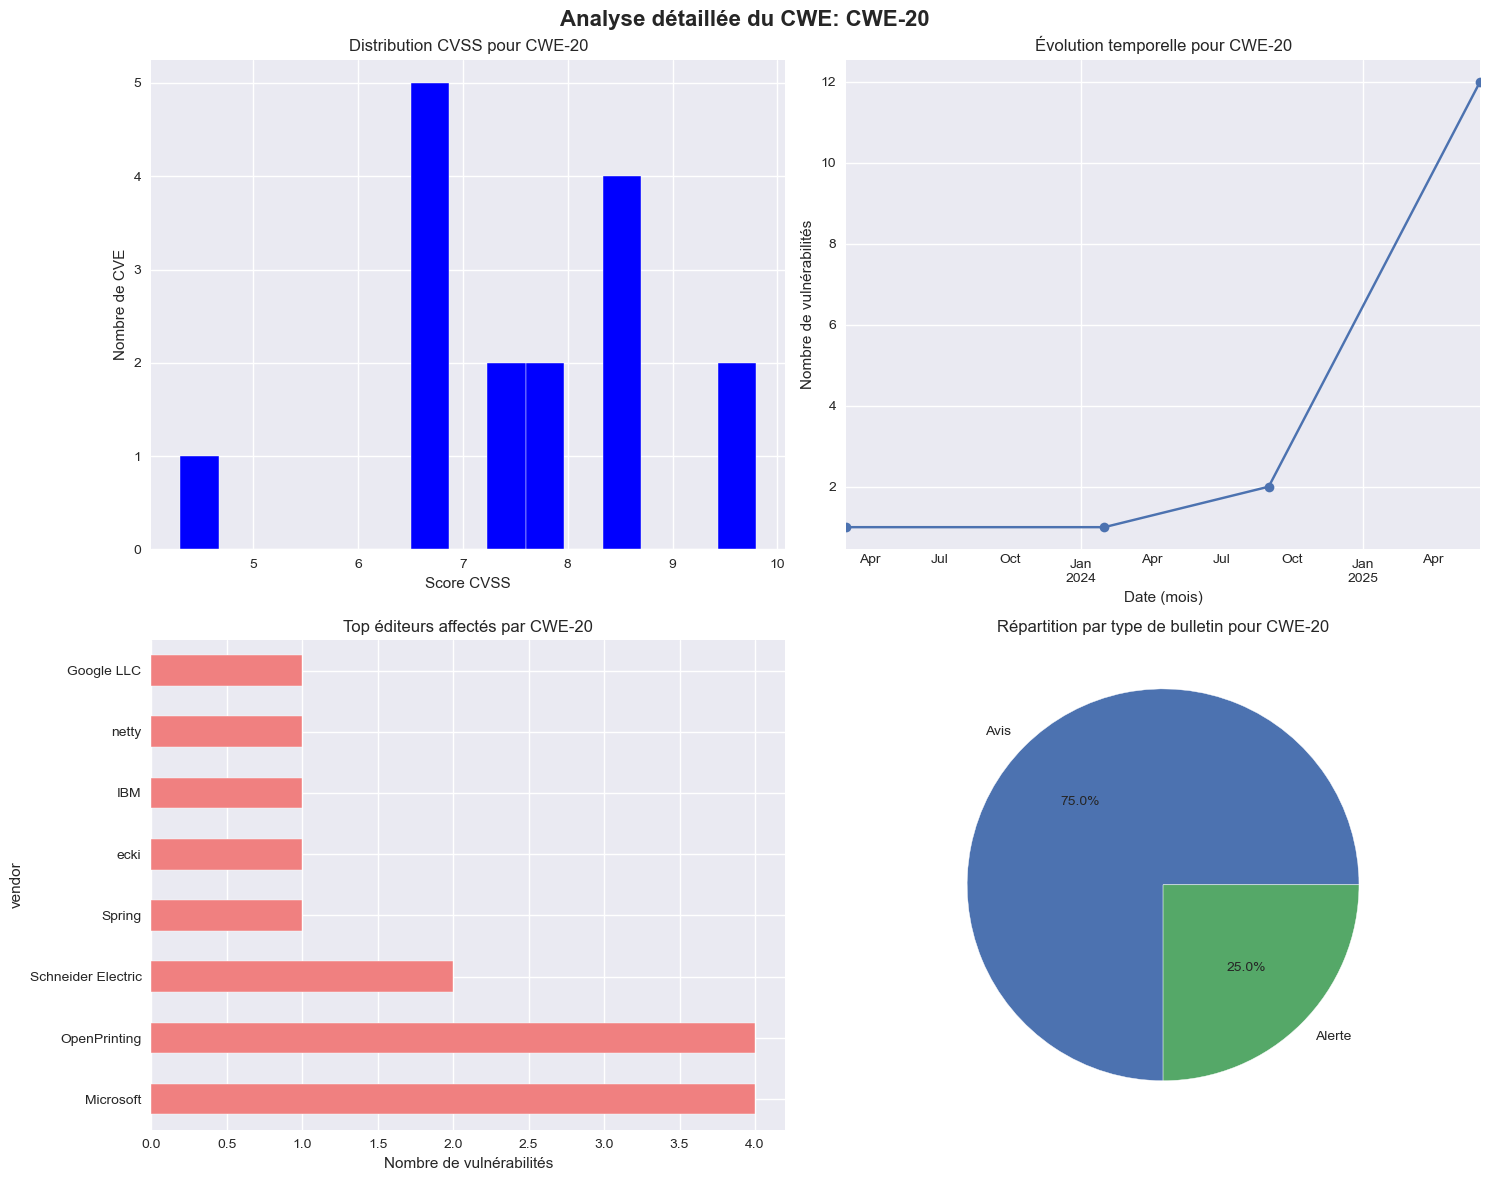

In [301]:
# top_cwe = df[df['type_cwe'] != 'Non disponible']['type_cwe'].value_counts().index[0]
top_cwe = 'CWE-20'
cwe_specific = df[df['type_cwe'] == top_cwe].copy()

print(f"Analyse du CWE: {top_cwe}")
print(f"Nombre de vulnérabilités: {len(cwe_specific)}")
# print(f"Description: {cwe_specific['cwe_desc'].iloc[0]}")

if len(cwe_specific) > 10:  # Seulement si suffisamment de données
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Historigramme CVSS
    ax1.hist(cwe_specific['cvss_score'].dropna(), bins=15, color='blue')
    ax1.set_title(f'Distribution CVSS pour {top_cwe}')
    ax1.set_xlabel('Score CVSS')
    ax1.set_ylabel('Nombre de CVE')

    # 2. Évolution temporelle
    if 'date' in cwe_specific.columns:
        cwe_temp = cwe_specific.dropna(subset=['date']).copy()
        cwe_temp['date'] = pd.to_datetime(cwe_temp['date'], errors='coerce')
        if hasattr(cwe_temp['date'].dt, 'tz'):
            cwe_temp['date'] = cwe_temp['date'].dt.tz_localize(None)

        cwe_temp['year_month'] = cwe_temp['date'].dt.to_period('M')
        monthly = cwe_temp.groupby('year_month').size()

        if not monthly.empty:
            monthly.plot(marker='o', ax=ax2)
            ax2.set_title(f"Évolution temporelle pour {top_cwe}")
            ax2.set_xlabel("Date (mois)")
            ax2.set_ylabel("Nombre de vulnérabilités")
            ax2.grid(True)
        else:
            ax2.text(0.5, 0.5, "Pas de données temporelles", ha='center')
            ax2.axis('off')

    # 3. Vendors les plus affectés
    cwe_vendors = cwe_specific['vendor'].dropna().astype(str)

    if not cwe_vendors.empty:
        vendor_counts = cwe_vendors.value_counts().head(10)
        vendor_counts.plot(kind='barh', ax=ax3, color='lightcoral')
        ax3.set_title(f'Top éditeurs affectés par {top_cwe}')
        ax3.set_xlabel('Nombre de vulnérabilités')
    else:
        ax3.text(0.5, 0.5, "Pas de données éditeur", ha='center')
        ax3.axis('off')

    # 4. Distribution par type de bulletin
    type_dist = cwe_specific['type'].value_counts()
    ax4.pie(type_dist.values, labels=type_dist.index, autopct='%1.1f%%')
    ax4.set_title(f'Répartition par type de bulletin pour {top_cwe}')

    plt.suptitle(f'Analyse détaillée du CWE: {top_cwe}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
most_frequent_cwe = df[df['type_cwe']!='Non disponible']['type_cwe'].mode().iloc[0]
lines_of_max_cwe = df[df['type_cwe']==most_frequent_cwe]
epss_of_max_cwe = lines_of_max_cwe['epss_score']
cvss_of_max_cwe = lines_of_max_cwe['cvss_score']
plt.plot(np.arange(len(lines_of_max_cwe)), epss_of_max_cwe, color='orange')
plt.plot(np.arange(len(lines_of_max_cwe)), cvss_of_max_cwe, color='red')
plt.legend(['EPSS score', 'CVSS score'])
plt.xlabel("Index de "+most_frequent_cwe)
plt.ylabel("Amplitude des scores")
plt.title("Evolution des scores du CWE le plus fréquent")

## Versions les plus fréquemment touchées des produits concernés

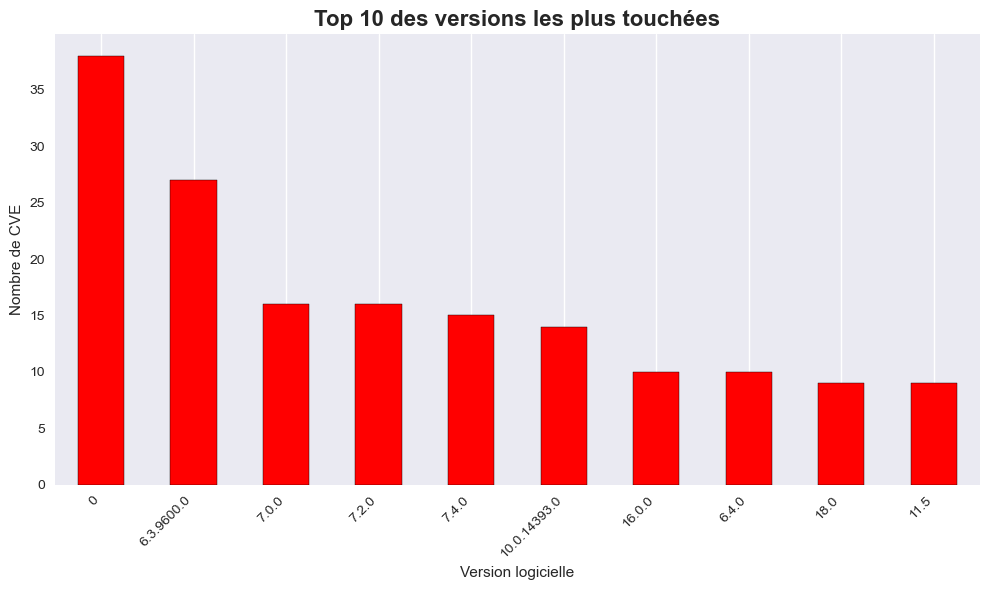

In [281]:
version_counts = df['versions'].dropna().str.split(', ').explode().value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
version_counts.plot(kind='bar', color='red', edgecolor='black')
plt.title("Top 10 des versions les plus touchées", fontsize=16, fontweight='bold')
plt.xlabel("Version logicielle")
plt.ylabel("Nombre de CVE")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Nombre de vulnérabilités par éditeur et type de bulletin (avis ou alerte)

<Figure size 1200x1000 with 0 Axes>

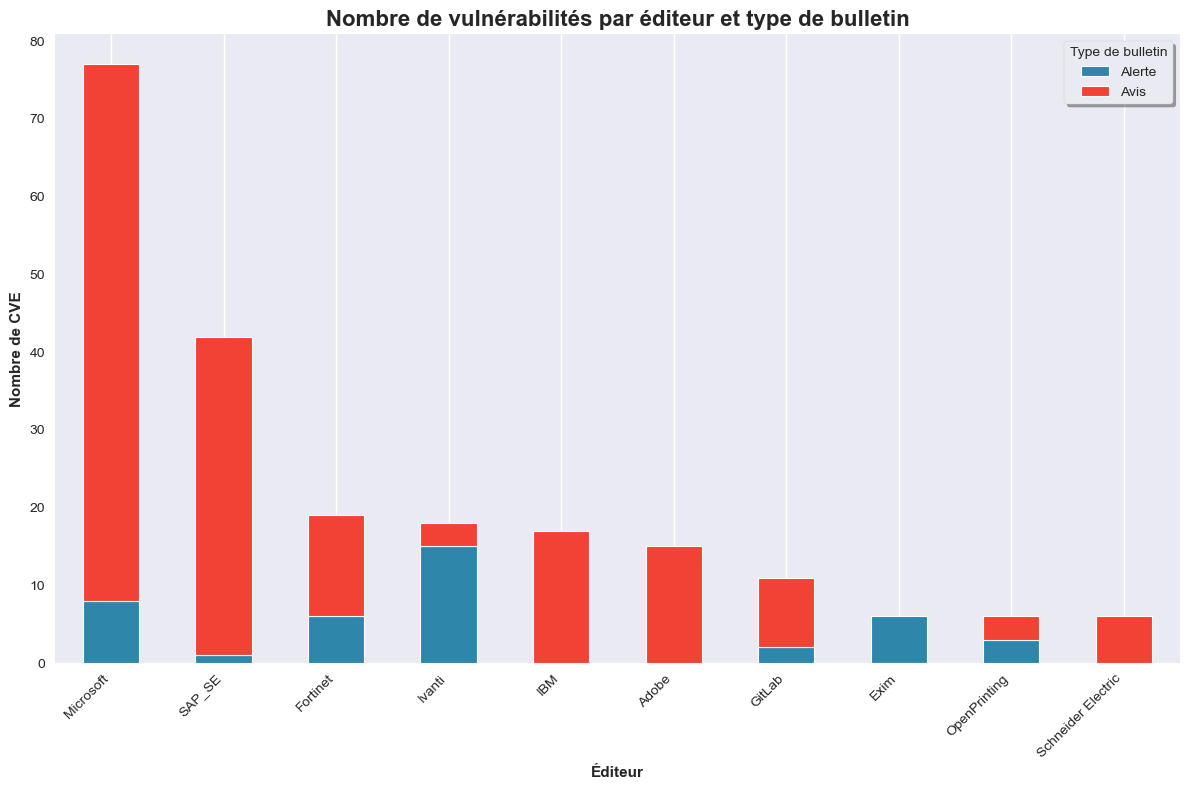

In [280]:
pivot = pd.pivot_table(df, values='cve_id', index='vendor', columns='type', aggfunc='count', fill_value=0)
top_vendors = pivot.sum(axis=1).nlargest(10).index

plt.figure(figsize=(12, 10))
pivot_subset = pivot.loc[top_vendors]

colors = ['#2E86AB', '#F24236']  # Blue and Red for better contrast
pivot_subset.plot(kind='bar', stacked=True, color=colors, edgecolor='white', linewidth=0.8)

plt.title("Nombre de vulnérabilités par éditeur et type de bulletin", fontsize=16, fontweight='bold')
plt.xlabel("Éditeur", fontweight='bold')
plt.ylabel("Nombre de CVE", fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Type de bulletin', frameon=True, fancybox=True, shadow=True)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Etape 6 : Génération d'Alertes et Notifications Email
Des alertes personnalisées sont générées lorsque des vulnérabilités critiques affectent
des logiciels spécifiques. Des notifications email sont envoyées aux abonnés.

**Mail destinataire :**
    mail : to.aiciDS5@gmail.com
    mdp : Aici@2004

**Mail envoyeur :**
    mail : from.aiciDS5@gmail.com
    mdp : Aici@2004
    mdp d'application : pmfakazcgvxwpkrq

In [279]:
import smtplib
from email.mime.text import MIMEText

# Paramètres de configuration
FROM_EMAIL = "from.aiciDS5@gmail.com"
APP_PASSWORD = "pmfakazcgvxwpkrq " # Aici@2004
TO_EMAIL = "to.aiciDS5@gmail.com"

def send_email(to_email, subject, body):
    msg = MIMEText(body)
    msg['From'] = FROM_EMAIL
    msg['To'] = to_email
    msg['Subject'] = subject

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(FROM_EMAIL, APP_PASSWORD)
        server.sendmail(FROM_EMAIL, to_email, msg.as_string())
        server.quit()
        print(f"Email envoyé à {to_email}")
    except Exception as e:
        print(f"Erreur lors de l'envoi de l'email : {e}")


def check_critical_vulnerabilities(csv_path):
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=["cvss_score", "epss_score"])
    df["cvss_score"] = df["cvss_score"].astype(float)
    df["epss_score"] = df["epss_score"].astype(float)

    # Seuils d’alerte
    critical = df[(df["cvss_score"] >= 9) | (df["epss_score"] >= 0.9)]

    for _, row in critical.iterrows():
        subject = f"ALERTE CVE CRITIQUE : {row['cve_id']}"
        body = (
            f"Titre : {row['title']}\n"
            f"Date : {row['date']}\n"
            f"CVE : {row['cve_id']}\n"
            f"Score CVSS : {row['cvss_score']}\n"
            f"Score EPSS : {row['epss_score']}\n"
            f"Produit : {row['product']}\n"
            f"Éditeur : {row['vendor']}\n"
            f"\nLien : {row['link']}\n"
            f"\nDescription :\n{row['description']}\n"
        )
        send_email(TO_EMAIL, subject, body)

In [ ]:
check_critical_vulnerabilities("data/test.csv")

# Etape 7 : Modèles de Machine Learning

## Préparation des données et Normalisation

In [278]:
# Créer la colonne cible contenant la classe de la vulnérabilité : 1 si EPSS >= 0.7 (risque d'exploitation important), 0 sinon
df['epss_high_risk'] = (df['epss_score'] >= 0.7).astype(int)

# Nombre de vulnérabilités par classe
print(df_ml['epss_high_risk'].value_counts(), "\n")

# Nettoyage des données
ml_df = df.dropna(subset=['cvss_score', 'epss_score', 'base_severity']) # Supprimer les lignes avec des valeurs manquantes dans les features critiques
print(f"Données après nettoyage: {len(ml_df)} lignes")

# Encodage de la sévérité en valeur numérique : (faible, moyenne, élevée, critique) -> (0, 1, 2, 3)
severity_encoder = LabelEncoder()
ml_df['severity_encoded'] = severity_encoder.fit_transform(ml_df['base_severity'])

# Préparation des features (CVSS et sévérité) et des labels (classe 0 ou 1)
features = ml_df[['cvss_score', 'severity_encoded']].copy() # On prédit le EPSS à partir du score CVSS et de la sévérité encodée
labels = ml_df['epss_high_risk'] # La valeur cible (que l'on cherche à prédire) est le risque EPSS élevé ou non
print(f"Features shape: {features.shape}") # Dimensions de la matrice features
print(f"\nFeatures statistiques:")
print(features.describe(), "\n") # Statistiques de la matrice features (moyenne, médiane, écart-type...)
print(features.head())

print(f"\nTarget shape: {labels.shape}")
print(f"\nTarget statistiques:")
print(labels.describe(), "\n")
print(labels.head())

# Vérifier qu'il reste suffisamment de données
if len(ml_df) < 10:
    print("\nPas assez de données pour le machine learning!")
else:
    print("\nDonnées suffisantes pour le machine learning")


# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
print(f"\nFeatures normalisées shape: {X_scaled.shape}")
print(f"Moyennes après normalisation: {X_scaled.mean(axis=0)}")
print(f"Écarts-types après normalisation: {X_scaled.std(axis=0)}")

epss_high_risk
0    290
1     40
Name: count, dtype: int64 

Données après nettoyage: 330 lignes
Features shape: (330, 2)

Features statistiques:
       cvss_score  severity_encoded
count   330.00000         330.00000
mean      6.85333           1.78788
std       1.74283           1.10147
min       0.00000           0.00000
25%       5.50000           1.00000
50%       7.30000           1.00000
75%       8.10000           3.00000
max      10.00000           4.00000 

   cvss_score  severity_encoded
0     3.10000                 2
1     4.10000                 3
2     6.40000                 3
3     6.30000                 3
4     3.10000                 2

Target shape: (330,)

Target statistiques:
count   330.00000
mean      0.12121
std       0.32687
min       0.00000
25%       0.00000
50%       0.00000
75%       0.00000
max       1.00000
Name: epss_high_risk, dtype: float64 

0    0
1    0
2    0
3    0
4    0
Name: epss_high_risk, dtype: int64

Données suffisantes pour le machine le

## Modèle supervisé 1 : Random Forest pour prédire les EPSS élevés (>= 0.7)
Objectif : prédire si une vulnérabilité a un risque d'exploitation important à partir de son score CVSS

In [285]:
# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42, stratify=labels)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation
print(f"\nScore d'accuracy: {clf.score(X_test, y_test):.3f}")
print("\nRapport de classification (Prédiction EPSS élevé):\n")
print(classification_report(y_test, y_pred))
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))

""" Raisons :
1. Déséquilibre entre les classes : classe 0 = 87% et classe 1 = 12%
2. Le lien entre score CVSS et score EPSS est faible
3. Manque de données contextuelles reliées à la probabilité d'exploitation d'une vulnérabilité
"""

# Explication pour le taux de précision de 50% sur la classe 1
print("\n", ml_df['epss_high_risk'].value_counts(normalize=True))


Score d'accuracy: 0.879

Rapport de classification (Prédiction EPSS élevé):

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        58
           1       0.50      0.50      0.50         8

    accuracy                           0.88        66
   macro avg       0.72      0.72      0.72        66
weighted avg       0.88      0.88      0.88        66


Matrice de confusion:
[[54  4]
 [ 4  4]]

 epss_high_risk
0   0.87879
1   0.12121
Name: proportion, dtype: float64


# Modèle supervisé 2 : Random Forest pour prédire le type de bulletin
Objectif : prédire le type de bulletin ('type') à partir des scores CVSS, EPSS et du type de vulnérabilité

In [291]:
ml_df = df.dropna(subset=['cvss_score', 'epss_score', 'type_cwe', 'type'])

# Encodage de la variable cible ('type' = Avis ou Alerte)
type_encoder = LabelEncoder()
ml_df['type_encoded'] = type_encoder.fit_transform(ml_df['type'])

# Encodage de 'type_cwe'
cwe_encoder = LabelEncoder()
ml_df['cwe_encoded'] = cwe_encoder.fit_transform(ml_df['type_cwe'])

# Features : CVSS + EPSS + CWE encodé
features = ml_df[['cvss_score', 'epss_score', 'cwe_encoded']]
labels = ml_df['type_encoded']

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42, stratify=labels)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Rapport de classification (Prédiction type de bulletin):")
print(classification_report(y_test, y_pred, target_names=type_encoder.classes_))
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

Rapport de classification (Prédiction type de bulletin):
              precision    recall  f1-score   support

      Alerte       0.67      0.73      0.70        11
        Avis       0.94      0.93      0.94        55

    accuracy                           0.89        66
   macro avg       0.81      0.83      0.82        66
weighted avg       0.90      0.89      0.90        66

Matrice de confusion:
[[ 8  3]
 [ 4 51]]


### Visualisation de la matrice de confusion

<Figure size 600x500 with 0 Axes>

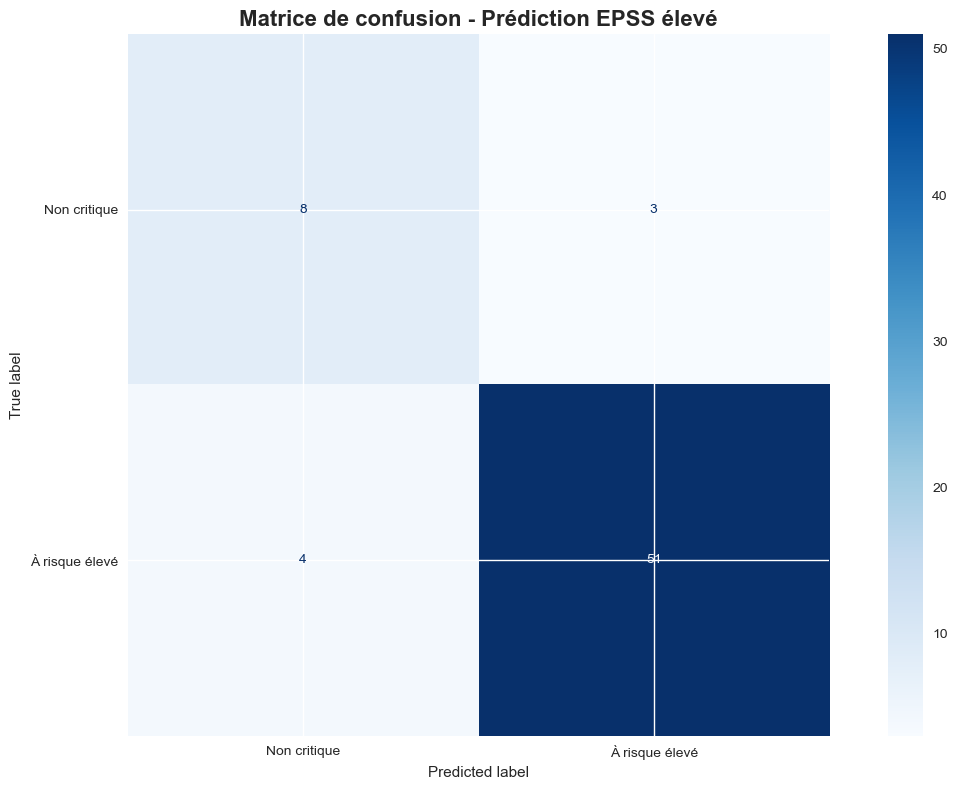

In [292]:
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['Non critique', 'À risque élevé'], cmap='Blues')
plt.title("Matrice de confusion - Prédiction EPSS élevé", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Visualisation de la courbe ROC-AUC

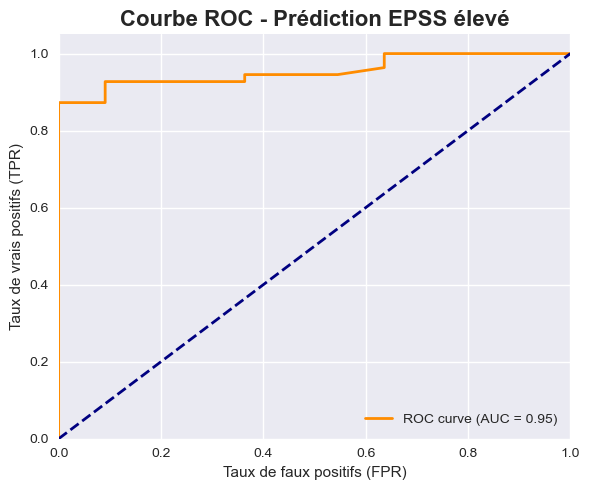

In [293]:
# Prédictions probabilistes pour la classe positive
y_probs = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Prédiction EPSS élevé', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualisation : importance des features

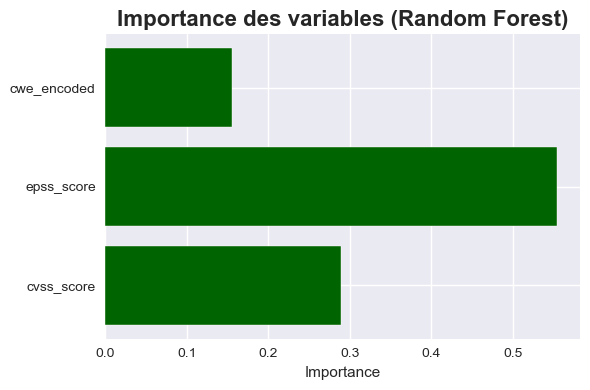

In [294]:
feature_names = features.columns
feature_importance = clf.feature_importances_
plt.figure(figsize=(6, 4))
plt.barh(feature_names, feature_importance, color='darkgreen')
plt.xlabel("Importance")
plt.title("Importance des variables (Random Forest)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Modèle non supervisé : KMeans sur CVSS et EPSS
Objectif : regrouper les vulnérabilités dans 4 clusters différents en fonction de leurs scores EPSS et CVSS

In [269]:
# Preparation des features (scores CVSS et EPSS
unsupervised_features = ml_df[['cvss_score', 'epss_score']]

# Normalisation de la matrice de features
X_unsup_scaled = scaler.fit_transform(unsupervised_features)

# Création du modèle KMeans avec 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_unsup_scaled)
ml_df['cluster'] = kmeans.labels_
print(ml_df.head())

# Sauvegarde du DataFrame avec clustering
ml_df.to_csv("data/final_cve_data_clustered.csv", index=False)
df.to_csv("data/final_cve_data_clustered.csv", index=False)

                     id                                              title  \
0  CERTFR-2025-AVI-0392  Multiples vulnérabilités dans Mattermost Serve...   
1  CERTFR-2025-AVI-0392  Multiples vulnérabilités dans Mattermost Serve...   
2  CERTFR-2025-AVI-0396  Multiples vulnérabilités dans les produits SAP...   
3  CERTFR-2025-AVI-0396  Multiples vulnérabilités dans les produits SAP...   
4  CERTFR-2025-AVI-0396  Multiples vulnérabilités dans les produits SAP...   

   type                             date          cve_id  cvss_score  \
0  Avis  Tue, 13 May 2025 00:00:00 +0000   CVE-2025-4128     3.10000   
1  Avis  Tue, 13 May 2025 00:00:00 +0000   CVE-2025-4573     4.10000   
2  Avis  Tue, 13 May 2025 00:00:00 +0000  CVE-2025-43003     6.40000   
3  Avis  Tue, 13 May 2025 00:00:00 +0000  CVE-2025-43007     6.30000   
4  Avis  Tue, 13 May 2025 00:00:00 +0000  CVE-2025-23191     3.10000   

  base_severity type_cwe  epss_score  \
0           LOW  CWE-863     0.00023   
1        MEDIUM   

### Visualisation : clusters KMeans avec centres (croix rouges)

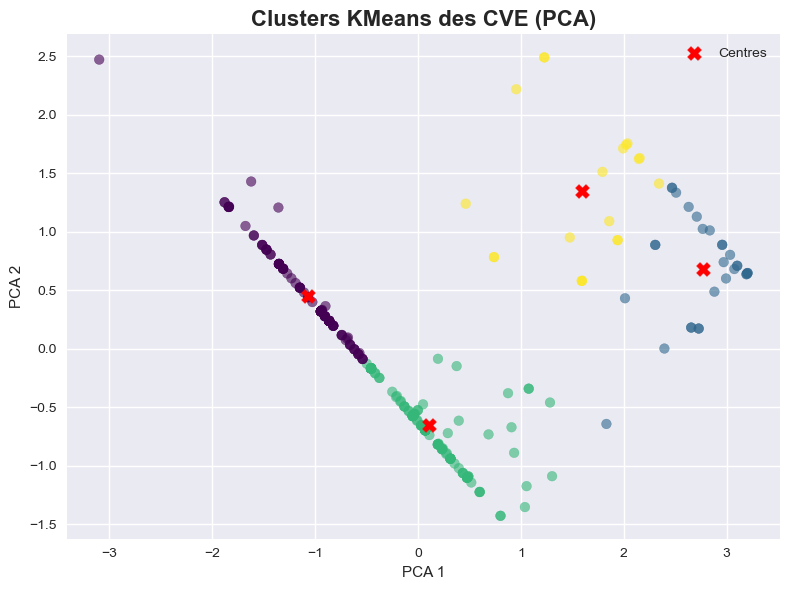


Résumé statistique par cluster (CVSS et EPSS):
        cvss_score               epss_score              
              mean     std count       mean     std count
cluster                                                  
0          4.98699 0.95041   123    0.00253 0.01233   123
1          9.42333 0.62350    30    0.86047 0.13255    30
2          7.78662 0.77890   157    0.01669 0.05410   157
3          7.15000 0.97630    20    0.75343 0.17480    20


In [273]:
# PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_unsup_scaled)
ml_df['pca1'] = X_pca[:, 0]
ml_df['pca2'] = X_pca[:, 1]

centers = pca.transform(kmeans.cluster_centers_)
plt.figure(figsize=(8, 6))
plt.scatter(ml_df['pca1'], ml_df['pca2'], c=ml_df['cluster'], cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='X', label='Centres')
plt.title("Clusters KMeans des CVE (PCA)", fontsize=16, fontweight='bold')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyse descriptive des clusters
cluster_summary = ml_df.groupby('cluster')[['cvss_score', 'epss_score']].agg(['mean', 'std', 'count'])
print("\nRésumé statistique par cluster (CVSS et EPSS):")
print(cluster_summary)